In [1]:
    import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2024-08-29 20:26:40.966953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 20:26:40.967068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 20:26:41.112052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [3]:
image_train=[]
im_height=256
im_width=256
mask_files=glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*")
for i in mask_files:
    image_train.append(i.replace('_mask',""))
print(image_train[:10])
print(len(image_train))

['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_7.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_6.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_38.tif']
3929


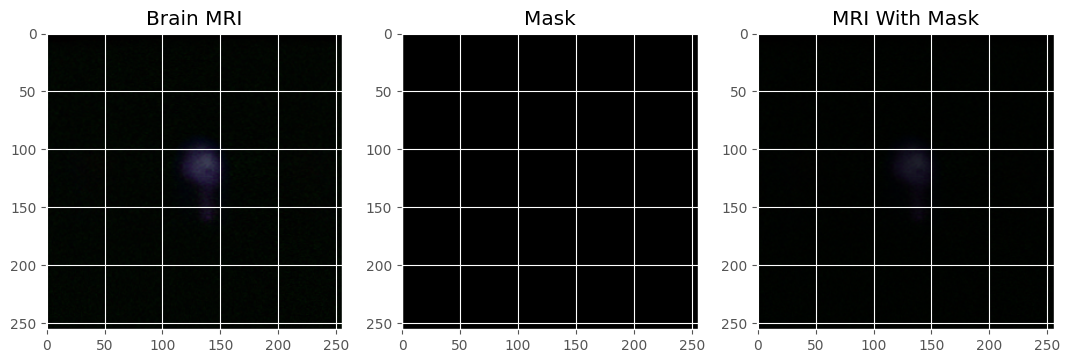

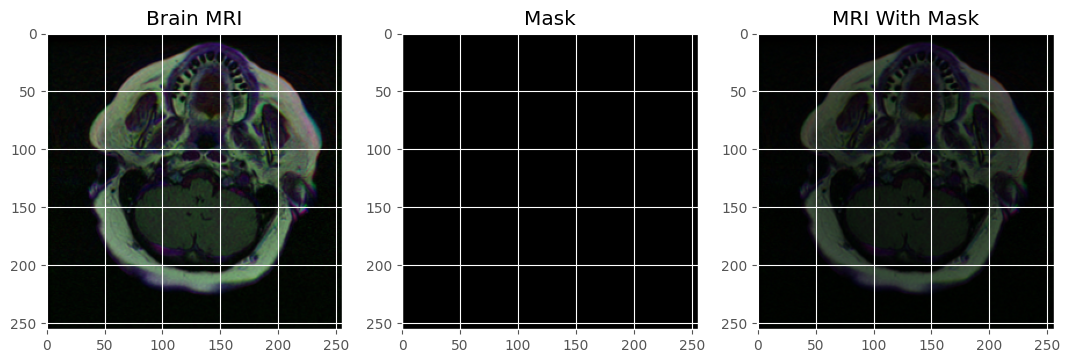

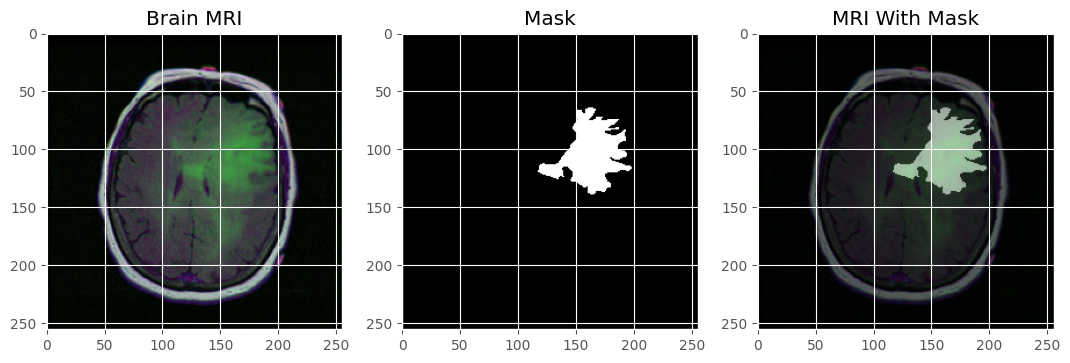

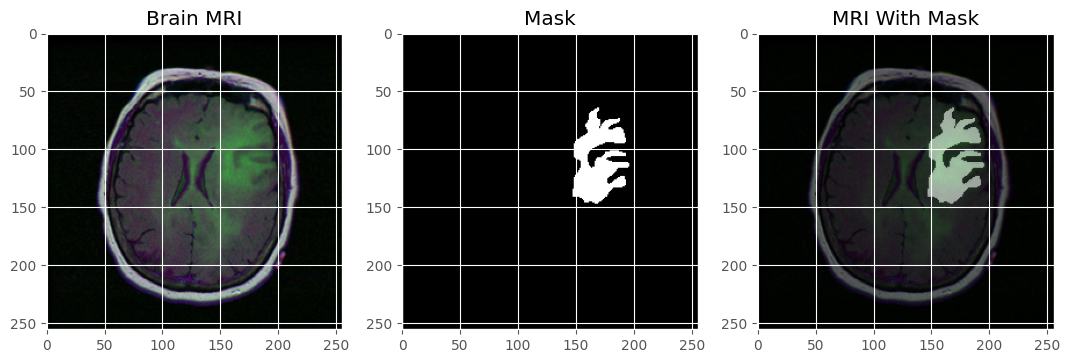

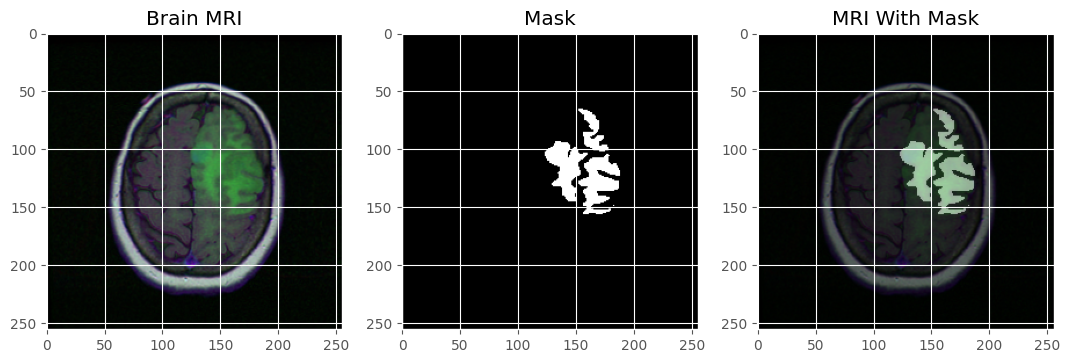

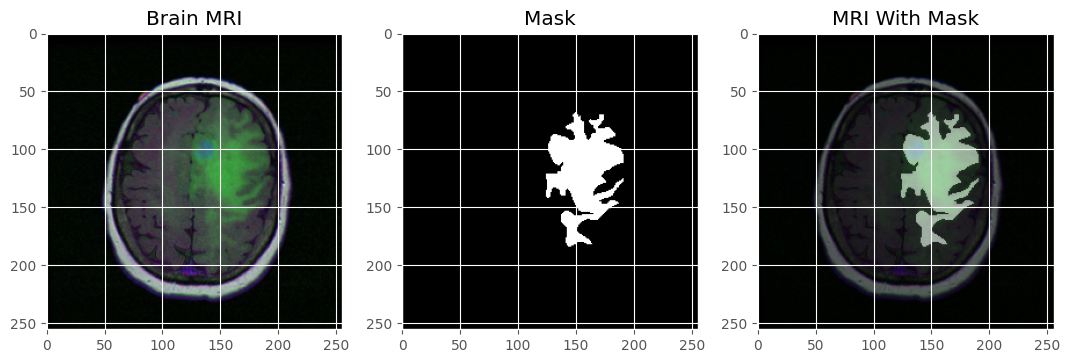

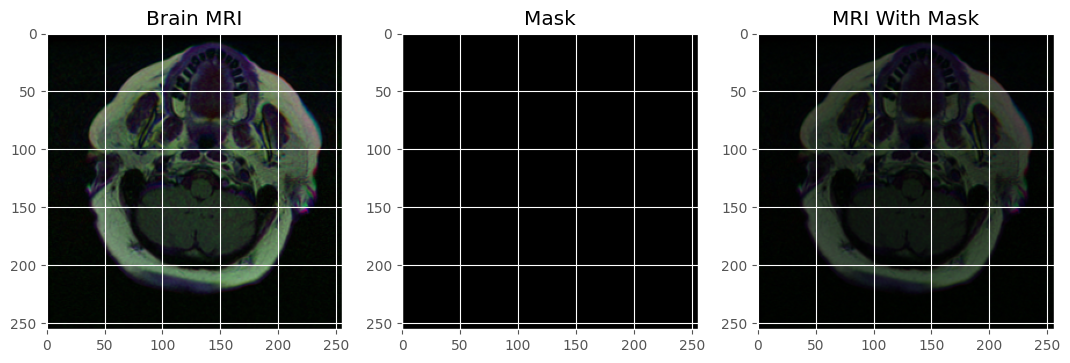

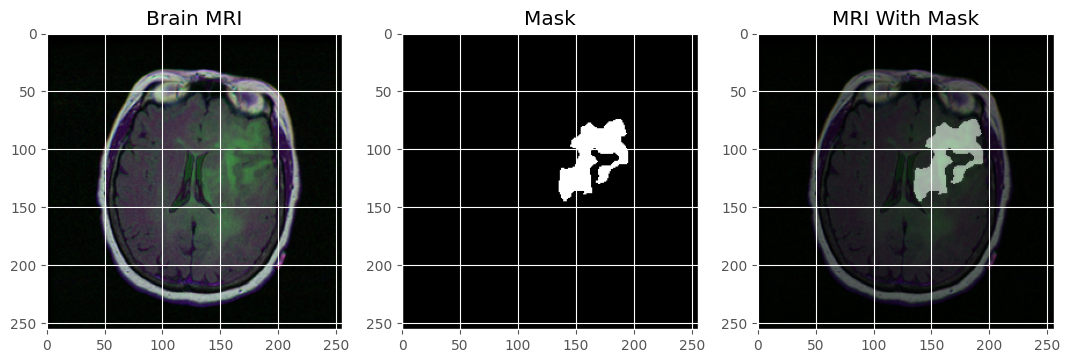

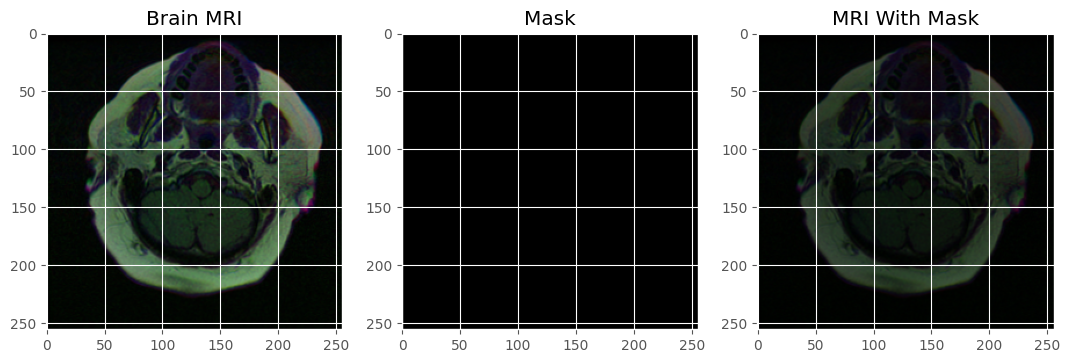

In [4]:
def plot_from_img_path(rows, columns, img_paths, mask_paths):
    for i in range(rows * columns):
        img_path = img_paths[i]
        mask_path = mask_paths[i]
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Ensure correct color conversion
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)    # Ensure correct color conversion
        
        # Add subplot and plot image with mask overlay
        fig , axs = plt.subplots(1,3,figsize=[13,15])
        axs[0].imshow(image)
        axs[0].set_title('Brain MRI')
    
        axs[1].imshow(mask)
        axs[1].set_title('Mask')
        
        axs[2].imshow(image)
        axs[2].imshow(mask,alpha=0.5)
        axs[2].set_title('MRI With Mask')

    plt.show()

# Example usage:
# Assuming image_train and mask_files are lists of file paths
plot_from_img_path(3, 3, image_train, mask_files)

In [5]:
df=pd.DataFrame(data={'image':image_train,'mask':mask_files})

In [6]:
df.head()

image  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                                mask  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [7]:
df_train,df_test=train_test_split(df,test_size=0.1)
df_train,df_val=train_test_split(df_train,test_size=0.2)

In [8]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


In [9]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)
    



In [10]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    

In [11]:
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [12]:

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    # Encoder

    conv2 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(bn5)

    conv6 = Conv2D(1024, (3, 3), padding='same')(pool5)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(1024, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    # Decoder
    up7 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn6), conv5], axis=3)
    conv7 = Conv2D(512, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(512, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn7), conv4], axis=3)
    conv8 = Conv2D(256, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(256, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn8), conv3], axis=3)
    conv9 = Conv2D(128, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(128, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    up10 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn9), conv2], axis=3)
    conv10 = Conv2D(64, (3, 3), padding='same')(up10)
    bn10 = Activation('relu')(conv10)
    conv10 = Conv2D(64, (3, 3), padding='same')(bn10)
    bn10 = BatchNormalization(axis=3)(conv10)
    bn10 = Activation('relu')(bn10)
    

    conv12 = Conv2D(1, (1, 1), activation='sigmoid')(bn10)

    return Model(inputs=[inputs], outputs=[conv12])

# Create the model
model = unet(input_size=(256, 256, 3))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]  

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [15]:
import tensorflow as tf



initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('mri_seg.keras', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // BATCH_SIZE, 
                    epochs=60, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) // BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/60


2024-08-29 20:29:12.031194: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.31777, expected 2.61172
2024-08-29 20:29:12.031268: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 5.10329, expected 4.39724
2024-08-29 20:29:12.031284: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.80913, expected 4.10308
2024-08-29 20:29:12.031294: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65544: 5.33366, expected 4.62762
2024-08-29 20:29:12.031308: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65545: 5.00267, expected 4.29663
2024-08-29 20:29:12.031325: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65546: 4.93559, expected 4.22954
2024-08-29 20:29:12.031339: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65547: 5.39283, expected 4.68678
2024-08-29 20:29:12.031350:

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - binary_accuracy: 0.8894 - dice_coef: 0.1226 - iou: 0.0675 - loss: -0.1226Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.24504, saving model to mri_seg.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - binary_accuracy: 0.8901 - dice_coef: 0.1233 - iou: 0.0679 - loss: -0.1233 - val_binary_accuracy: 0.9899 - val_dice_coef: 0.2450 - val_iou: 0.1437 - val_loss: -0.2450
Epoch 2/60


2024-08-29 20:32:45.805534: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.59143, expected 2.72011
2024-08-29 20:32:45.805601: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.91216, expected 3.04084
2024-08-29 20:32:45.805614: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.94757, expected 4.07625
2024-08-29 20:32:45.805626: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.44113, expected 4.56981
2024-08-29 20:32:45.805636: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.12543, expected 4.25411
2024-08-29 20:32:45.805647: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.68197, expected 4.81064
2024-08-29 20:32:45.805660: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.63124, expected 4.75992
2024-08-29 20:32:45.805674: E external/local_xla/xla/se

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - binary_accuracy: 0.9884 - dice_coef: 0.3882 - iou: 0.2518 - loss: -0.3941

2024-08-29 20:34:35.805915: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.24577, expected 2.80959
2024-08-29 20:34:35.805969: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 179: 3.17396, expected 2.73778
2024-08-29 20:34:35.806434: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.15611, expected 2.41005
2024-08-29 20:34:35.806455: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 3.84262, expected 3.09657
2024-08-29 20:34:35.806463: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.59187, expected 3.84581
2024-08-29 20:34:35.806472: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65539: 5.43123, expected 4.68518
2024-08-29 20:34:35.806479: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65540: 5.1009, expected 4.35484
2024-08-29 20:34:35.806487: E exte


Epoch 2: val_loss did not improve from -0.24504
88/88 ━━━━━━━━━━━━━━━━━━━━ 125s 832ms/step - binary_accuracy: 0.9884 - dice_coef: 0.3890 - iou: 0.2524 - loss: -0.3948 - val_binary_accuracy: 0.4869 - val_dice_coef: 0.0370 - val_iou: 0.0189 - val_loss: -0.0377
Epoch 3/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - binary_accuracy: 0.9931 - dice_coef: 0.5782 - iou: 0.4240 - loss: -0.5938
Epoch 3: val_loss did not improve from -0.24504
88/88 ━━━━━━━━━━━━━━━━━━━━ 64s 728ms/step - binary_accuracy: 0.9931 - dice_coef: 0.5787 - iou: 0.4244 - loss: -0.5941 - val_binary_accuracy: 0.9327 - val_dice_coef: 0.2053 - val_iou: 0.1174 - val_loss: -0.2121
Epoch 4/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - binary_accuracy: 0.9922 - dice_coef: 0.5766 - iou: 0.4305 - loss: -0.5853
Epoch 4: val_loss improved from -0.24504 to -0.46328, saving model to mri_seg.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 66s 746ms/step - binary_accuracy: 0.9922 - dice_coef: 0.5773 - iou: 0.4311 - loss: -0.5860 - val_binary_accuracy: 0

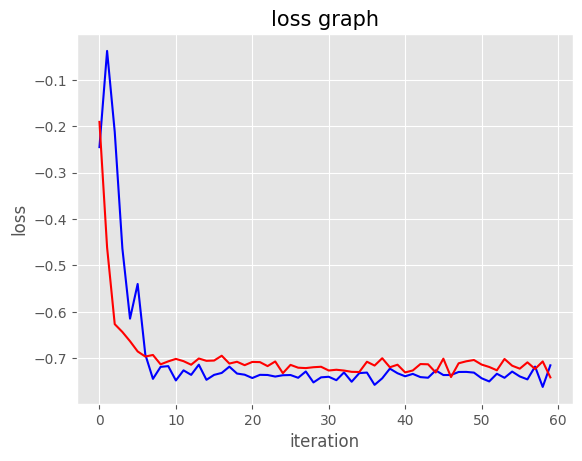

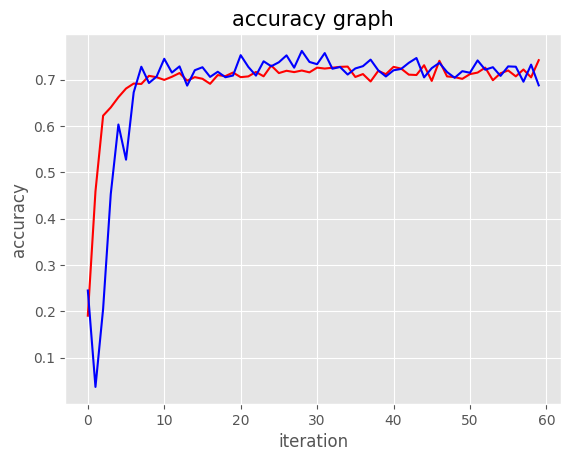

In [16]:

a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()


In [17]:
new_model = load_model('mri_seg.keras', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [19]:

test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = new_model.evaluate(test_gen, steps=len(df_test) // BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 421ms/step - binary_accuracy: 0.9948 - dice_coef: 0.6606 - iou: 0.5036 - loss: -0.6606
Test lost:  -0.6822221875190735
Test IOU:  0.9947426915168762
Test Dice Coefficent:  0.5256602168083191


2024-08-29 21:38:46.664624: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.86272, expected 2.0465
2024-08-29 21:38:46.664683: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.04967, expected 3.23345
2024-08-29 21:38:46.664693: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.4326, expected 3.61638
2024-08-29 21:38:46.664703: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.46868, expected 4.65247
2024-08-29 21:38:46.664712: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.37814, expected 4.56193
2024-08-29 21:38:46.664721: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.18374, expected 4.36753
2024-08-29 21:38:46.664730: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.54872, expected 4.7325
2024-08-29 21:38:46.664739: E external/local_xla/xla/servi

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


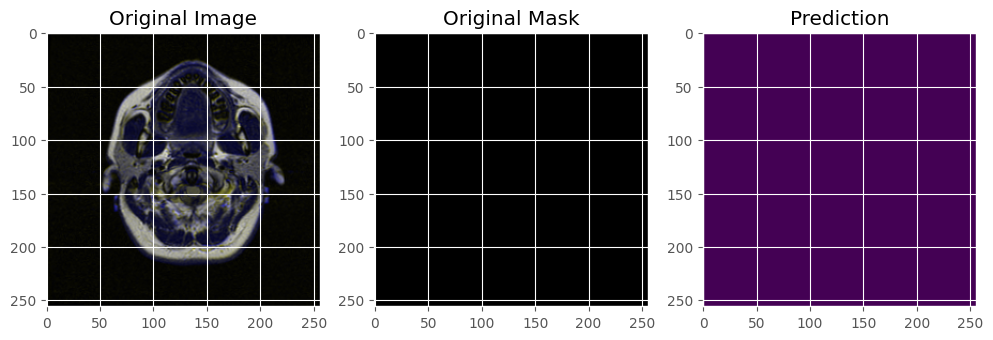

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


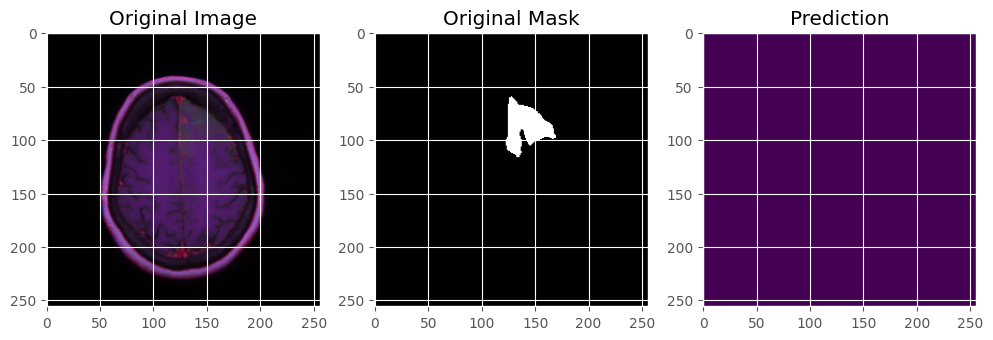

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


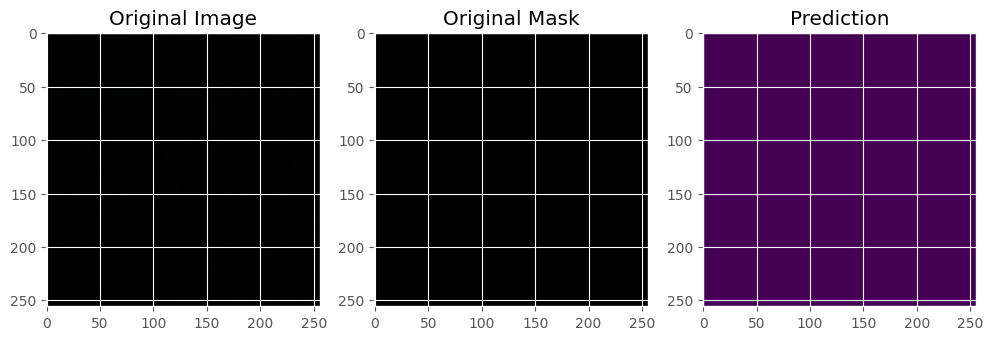

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


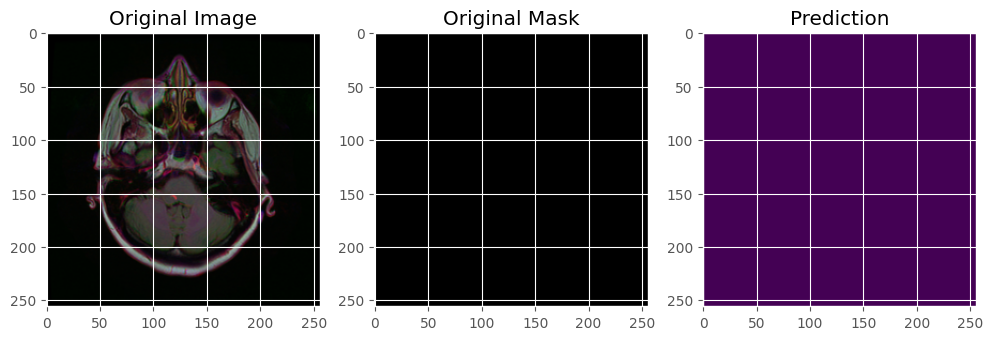

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


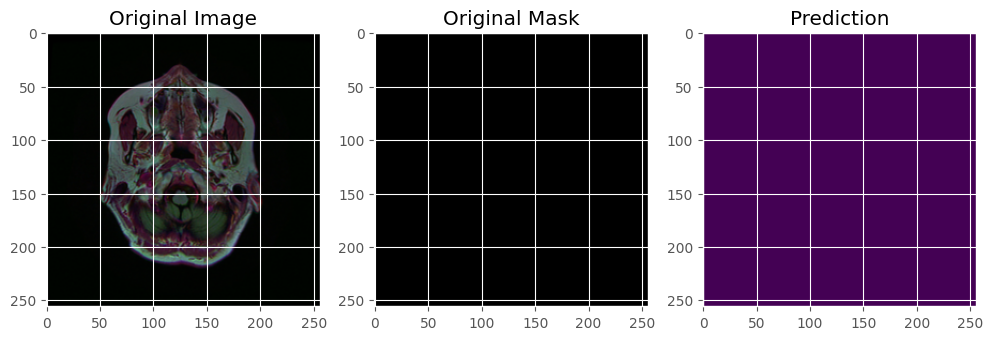

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


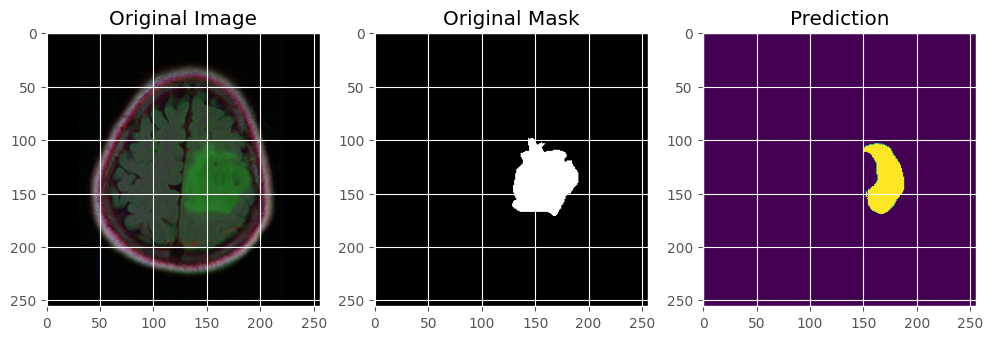

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


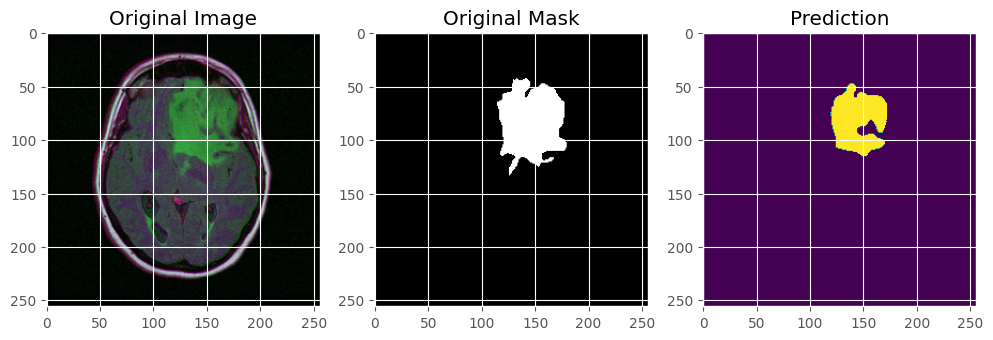

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


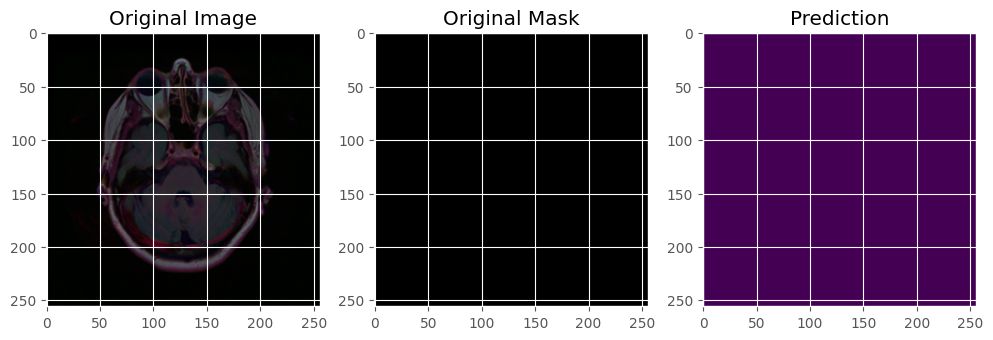

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


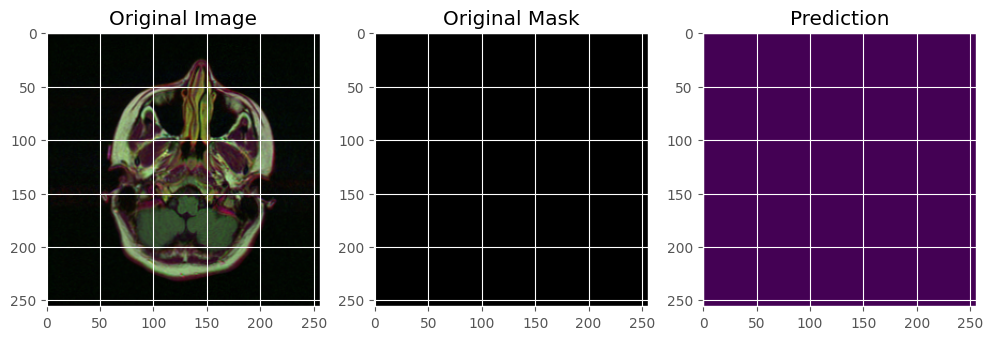

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


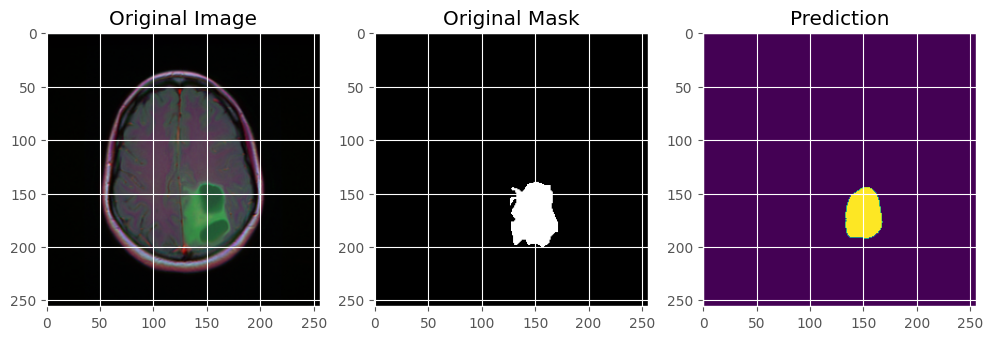

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


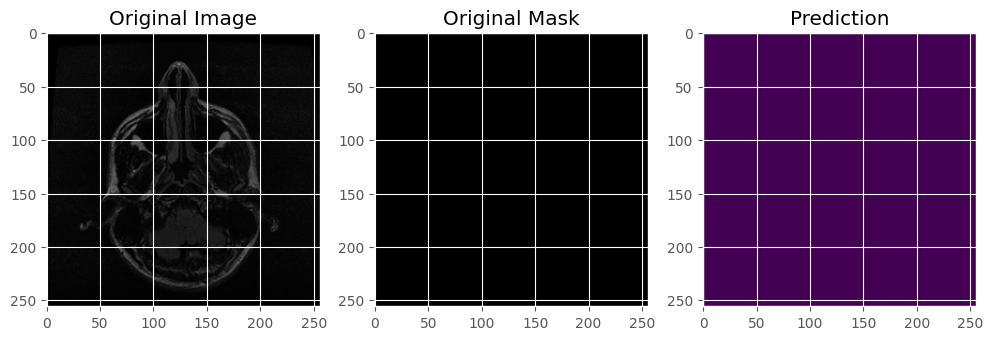

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


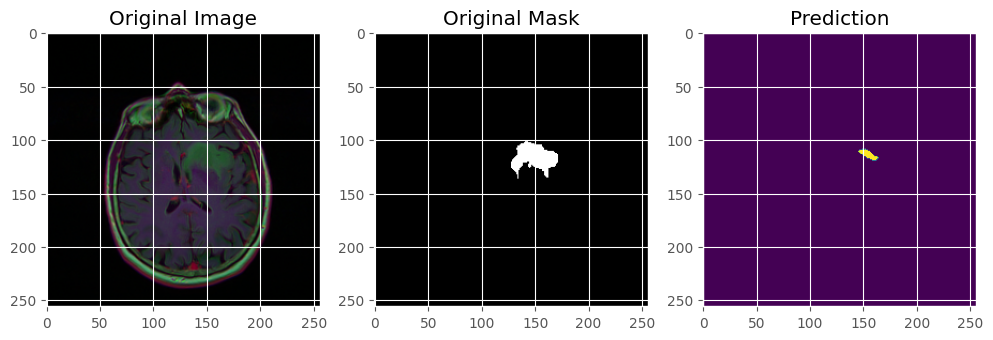

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


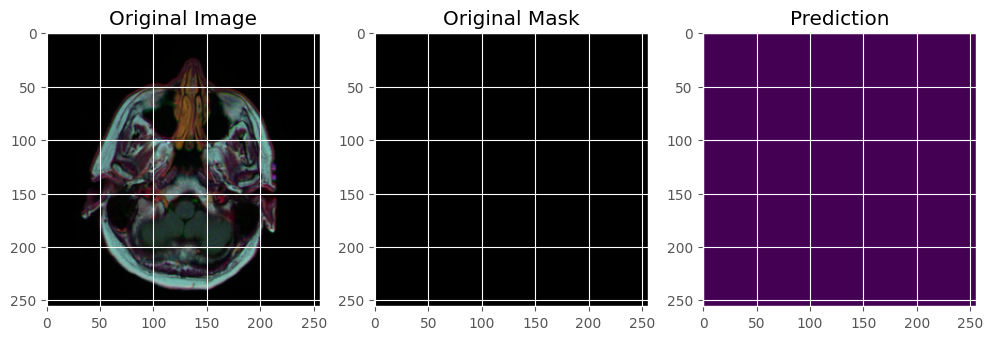

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


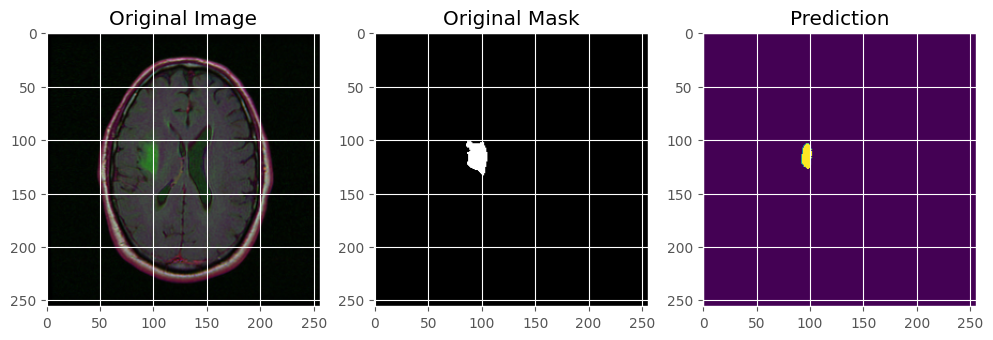

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


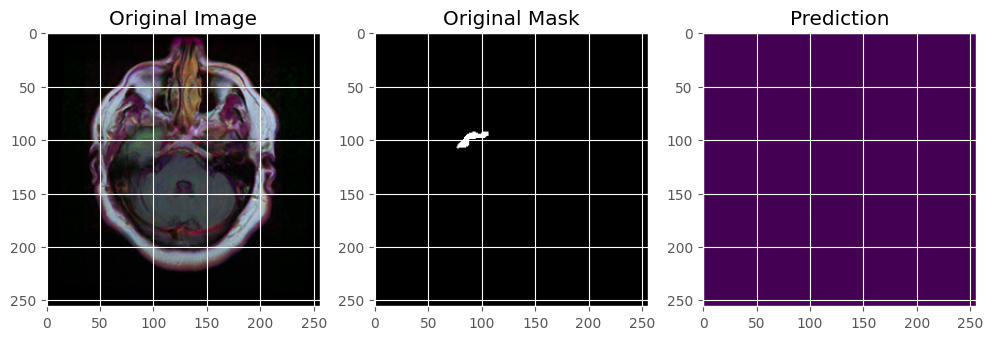

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


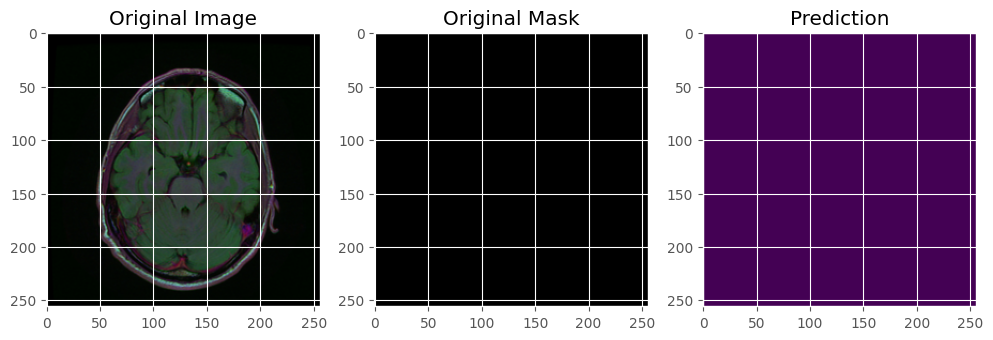

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


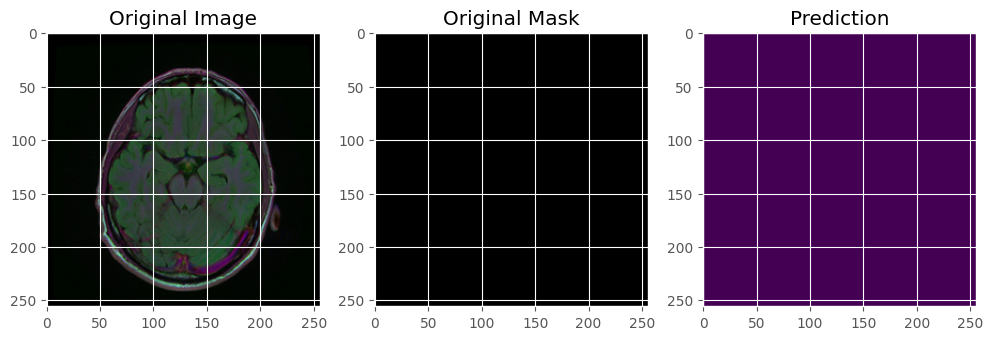

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


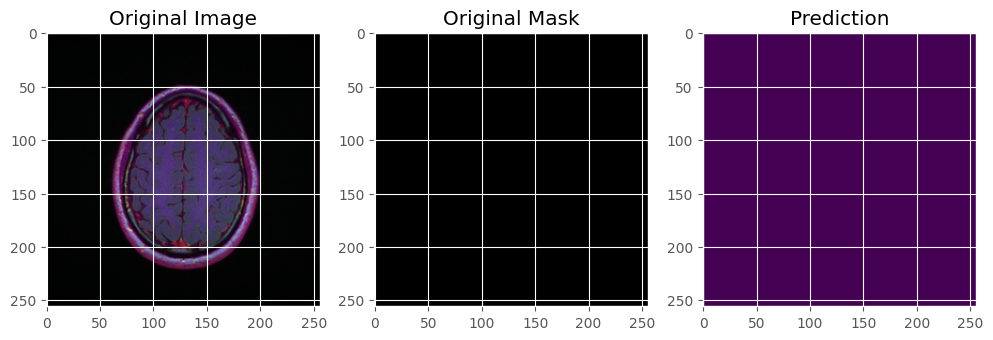

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


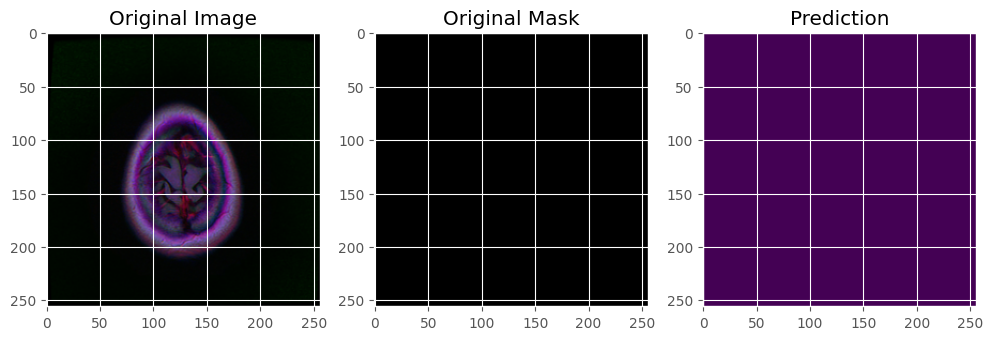

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


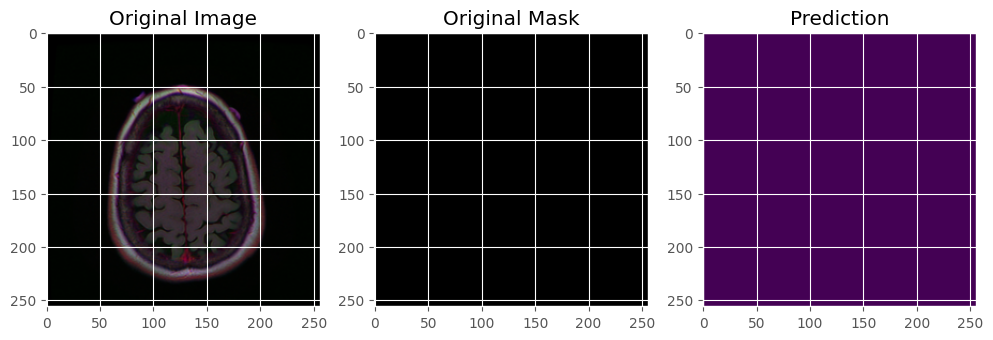

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


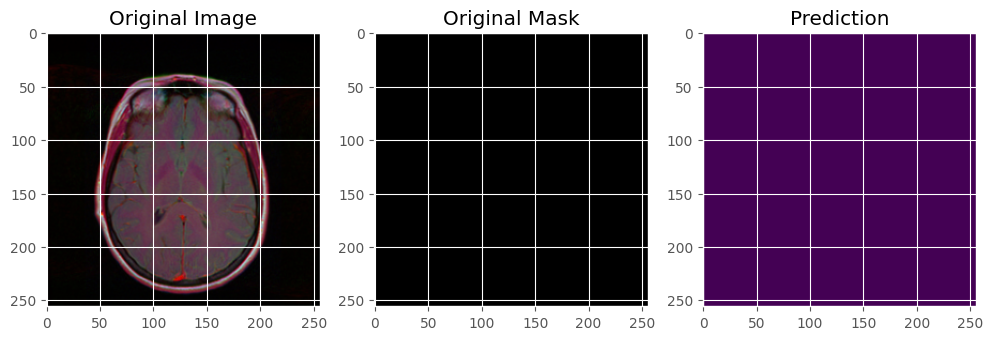

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


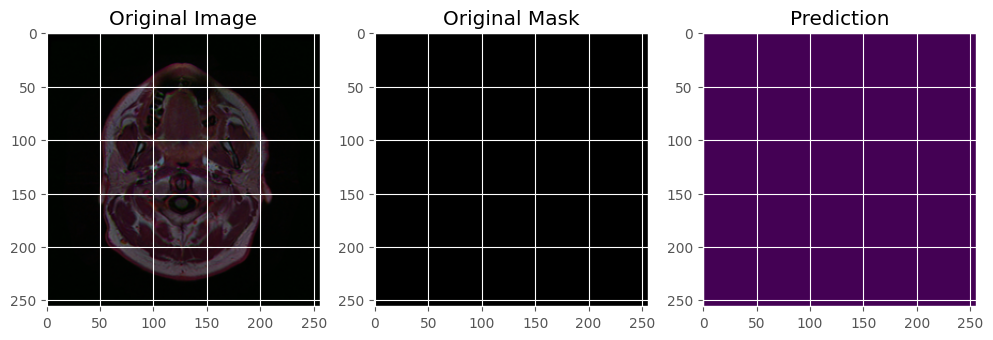

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


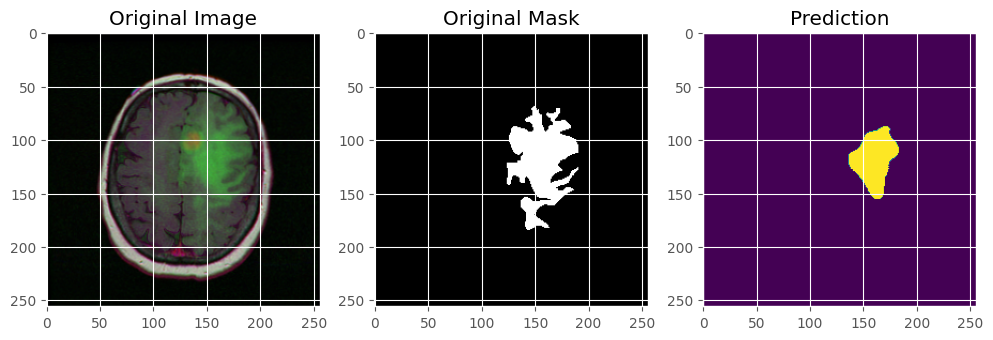

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


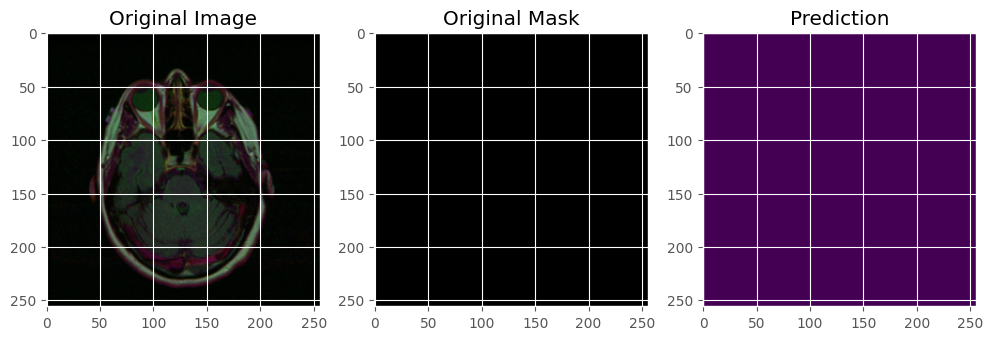

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


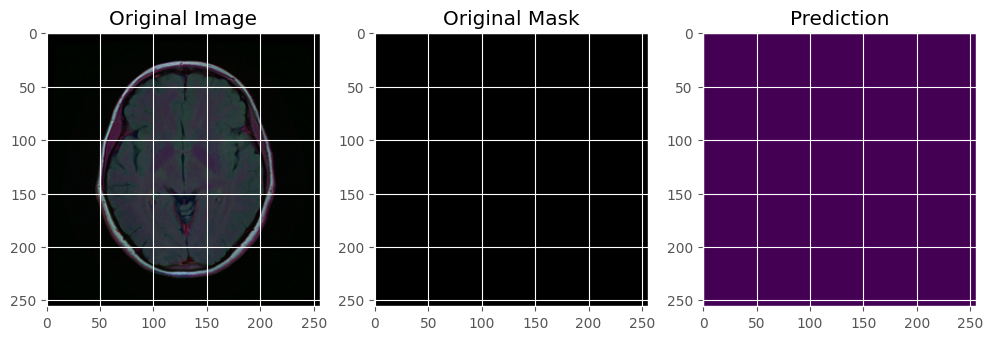

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


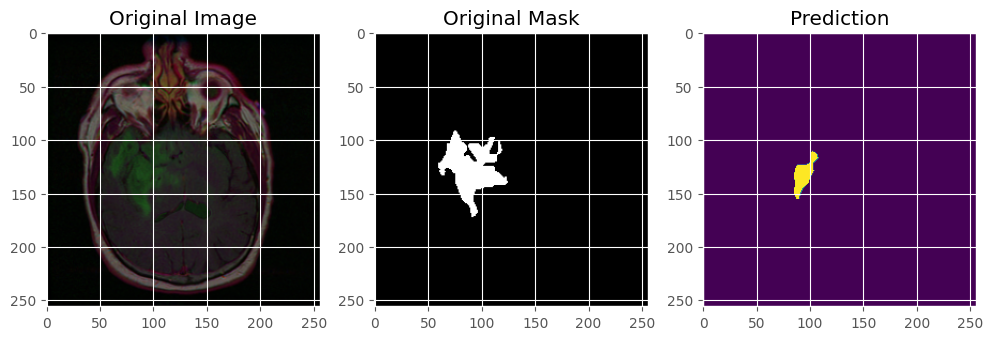

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


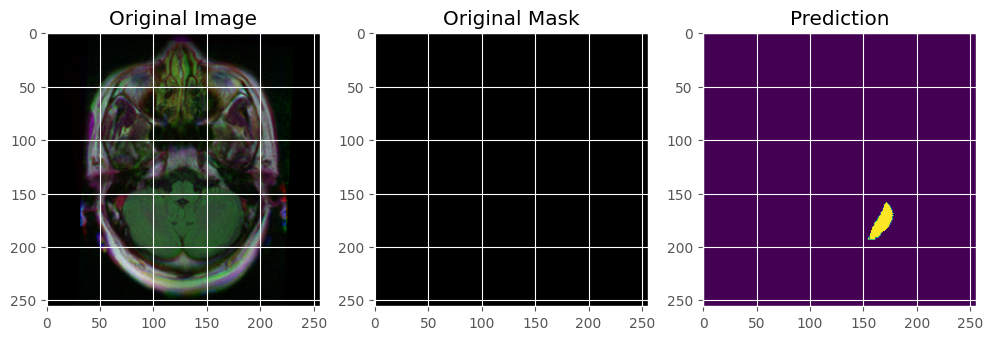

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


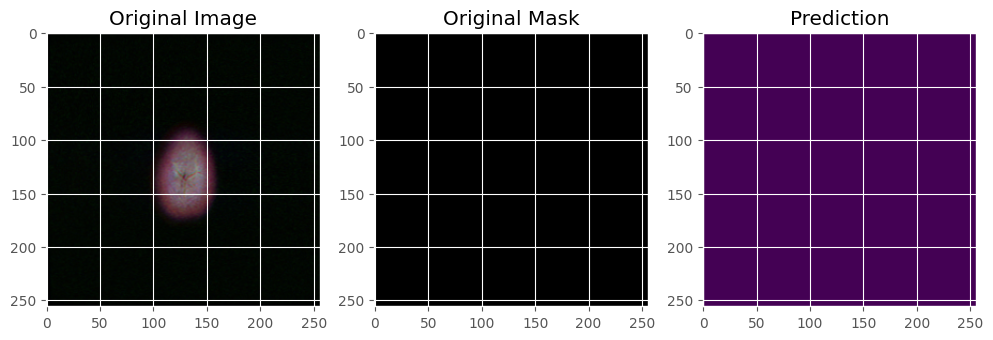

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


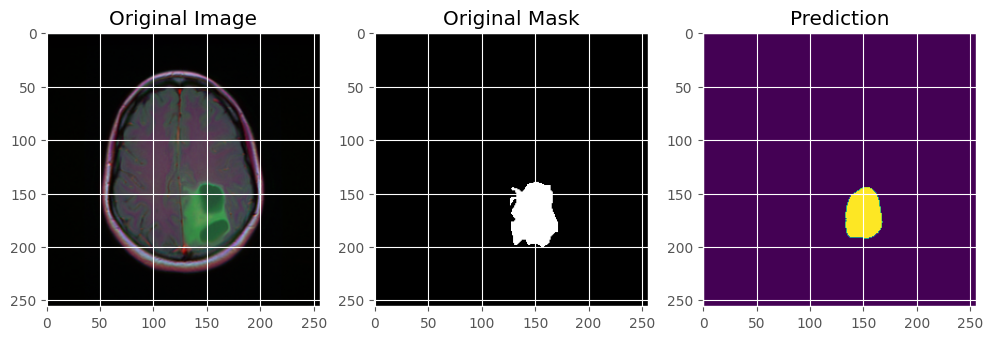

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


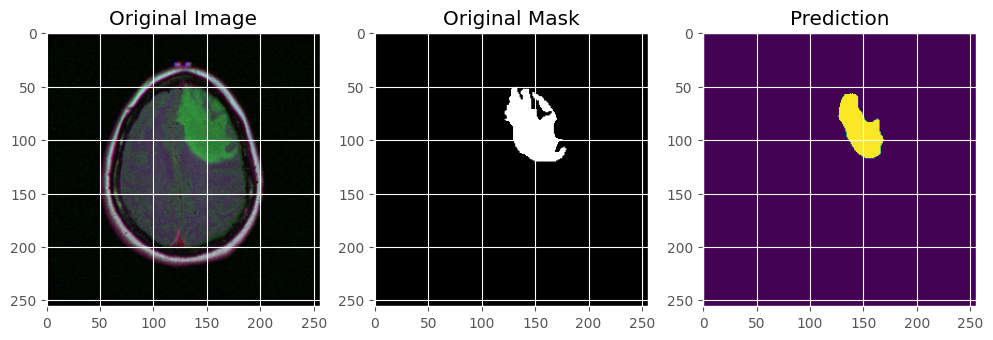

In [21]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()
